Potential evapotranspiration (PET), reference evapotranspiration (ET₀), and actual evapotranspiration (AET) are key concepts to understand and qunatify the soil water balance in agriculture and hydrology. PET refers to the amount of water that would be lost through evapotranspiration if there were an unlimited water supply (e.g., a lake); it's a theoretical maximum based on environmental conditions like temperature, humidity, wind speed, and solar radiation. ET₀ is a subset of PET, and represents a measure of evapotranspiration from a specific reference crop under well-watered conditions, and serves as a baseline for comparing water requirements across different crops and regions. In contrast, AET represents the real amount of water lost due to evapotranspiration from a specific crop or vegetation cover, which is largely modulated by soil moisture availability that can limit the evapotranspiration process. AET is often lower than PET and ET₀, especially in water-limited environments. These three metrics are relevant in water resource management, irrigation planning, and understanding plant-water relations across different climatic conditions.

Over the years, scientists developed several models to estimate PET and ET₀. Early models, like the Dalton and Penman models, only relied on vapor pressure deficit and wind speed based on mass-transfer principles. Later models, like the Jensen-Haise and Hargreaves models, accounted for energy balance components by considering extraterrestrial radiation solar radiation. More recent models, like the Penman-Monteith model, combine the principles of energy balance, aerodynamic resistance, and canopy resistance, offering a more accurate and reliable estimation of ET₀ across diverse climatic conditions. The Penman-Monteith is widely regarded as the standard method for ET₀.

This exercise is aimed at comparing several of these models using a dataset of weather observations.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Define auxiliary functions

THe following functions to compute the saturation vapor pressure and the extraterrestrial solar radiation appear in more than one model, so to avoid repeating code, we will define a function for each of them.

In [2]:
def compute_esat(T):
    """Function that computes saturation vapor pressure based Tetens formula"""
    e_sat = 0.6108 * np.exp(17.27 * T/(T+237.3)) 
    return e_sat

def compute_Ra(doy, latitude):
    """Function that computes extra-terrestrial solar radiation"""
    dr = 1 + 0.033 * np.cos(2 * np.pi * doy/365) # Inverse relative distance Earth-Sun
    phi = np.pi / 180 * latitude # Latitude in radians
    d = 0.409 * np.sin((2 * np.pi * doy/365) - 1.39) # Solar delcination
    omega = np.arccos(-np.tan(phi) * np.tan(d)) # Sunset hour angle
    Gsc = 0.0820 # Solar constant
    Ra = 24 * 60 / np.pi * Gsc * dr * (omega * np.sin(phi) * np.sin(d) + np.cos(phi) * np.cos(d) * np.sin(omega))
    return Ra


## Dalton model
In 1802, John Dalton proposed a model for predicting open-water evaporation, considering wind speed and vapor pressure deficit. While effective for open water bodies, the model doesn't account for plant and soil effects. This model is classified as a mass-transfer model, which describes water vapor moving along a gradient, which is maintained or enhanced by wind. This wind action replaces the moisture-saturated air near the evaporation surface with drier air, effectively sustaining the vapor gradient

$$ E = u(e_{s} - e_{a})$$

$u$ is the wind speed in m/s<br>
$e_s$ is the atmospheric saturation vapor pressure in kPa<br>
$e_a$ is the actual atmospheric vapor pressure<br>


In [3]:
## John Dalton (1802)

def dalton(T_min,T_max,RH_min,RH_max,wind_speed):
    """Potential evaporation model proposed by Dalton in 1802"""
    e_sat_min = compute_esat(T_min)
    e_sat_max = compute_esat(T_max)
    e_sat = (e_sat_min + e_sat_max)/2
    e_atm = (e_sat_min*(RH_max/100) + e_sat_max*(RH_min/100))/ 2
    PE = (3.648 + 0.7223*wind_speed)*(e_sat - e_atm)
    return PE


## Penman model

In [4]:
## Penman (1948)

def penman(T_min,T_max,RH_min,RH_max,wind_speed):
    """Potential evapotranspiration model proposed by Penman in 1948"""
    e_sat_min = compute_esat(T_min)
    e_sat_max = compute_esat(T_max)
    e_sat = (e_sat_min + e_sat_max)/2
    e_atm = (e_sat_min*(RH_max/100) + e_sat_max*(RH_min/100))/ 2
    PET = (2.625 + 0.000479/wind_speed)*(e_sat - e_atm)
    return PET


## Romanenko model

In [5]:
## Romanenko (1961)

def romanenko(T_min,T_max,RH_min,RH_max):
    """Potential evaporation model proposed by Romanenko in 1961"""
    T_avg = (T_min + T_max)/2
    RH_avg = (RH_min + RH_max)/2
    PET = 0.00006*(25 + T_avg)**2*(100 - RH_avg)
    return PET


## Jensen-Haise model

In [6]:
## Jensen-Haise (1963)

def jensen_haise(T_min,T_max,doy,latitude):
    """Potential evapotranspiration model proposed by Jensen in 1963"""
    Ra = compute_Ra(doy, latitude)
    T_avg = (T_min + T_max)/2
    PET = 0.0102 * (T_avg+3) * Ra
    return PET


## Hargreaves model

$$ PET = 0.0023 \ R_a \ (T_{avg} + 17.8) \ \sqrt{ (T_{max} - T_{min}) }$$

$R_a$ is the extraterrestrial solar radiation ($MJ/m^2$)<br>
$T_{max}$ is the maximum daily air temperature<br>
$T_{min}$ is the minimum daily air temperature<br>
$T_{avg}$ is the average daily air temperature<br>


In [7]:
## Hargreaves (1982)

def hargreaves(T_min,T_max,doy,latitude):
    """Potential evapotranspiration model proposed by Hargreaves in 1982"""
    Ra = compute_Ra(doy, latitude)
    T_avg = (T_min + T_max)/2
    PET = 0.0023 * Ra * (T_avg + 17.8) * (T_max - T_min)**0.5
    return PET


## Penman-Monteith model

In [8]:
def penman_monteith(T_min,T_max,RH_min,RH_max,solar_rad,wind_speed,doy,latitude,altitude):
    T_avg = (T_min + T_max)/2
    atm_pressure = 101.3 * ((293 - 0.0065 * altitude) / 293)**5.26 # Can be also obtained from weather station
    Cp = 0.001013; # Approx. 0.001013 for average atmospheric conditions
    epsilon =  0.622
    Lambda = 2.45
    gamma = (Cp * atm_pressure) / (epsilon * Lambda) # Approx. 0.000665

    ##### Wind speed
    wind_height = 1.5 # Most common height in meters
    wind_speed_2m = wind_speed * (4.87 / np.log((67.8 * wind_height) - 5.42))  # Eq. 47, FAO-56 wind height in [m]

    ##### Air humidity and vapor pressure
    delta = 4098 * (0.6108 * np.exp(17.27 * T_avg / (T_avg  + 237.3))) / (T_avg  + 237.3)**2
    e_temp_max = 0.6108 * np.exp(17.27 * T_max / (T_max + 237.3)) # Eq. 11, //FAO-56
    e_temp_min = 0.6108 * np.exp(17.27 * T_min / (T_min + 237.3))
    e_saturation = (e_temp_max + e_temp_min) / 2
    e_actual = (e_temp_min * (RH_max / 100) + e_temp_max * (RH_min / 100)) / 2

    ##### Solar radiation
    
    # Extra-terrestrial solar radiation
    dr = 1 + 0.033 * np.cos(2 * np.pi * doy/365)  # Eq. 23, FAO-56
    phi = np.pi / 180 * latitude # Eq. 22, FAO-56
    d = 0.409 * np.sin((2 * np.pi * doy/365) - 1.39)
    omega = np.arccos(-np.tan(phi) * np.tan(d))
    Gsc = 0.0820 # Approx. 0.0820
    Ra = 24 * 60 / np.pi * Gsc * dr * (omega * np.sin(phi) * np.sin(d) + np.cos(phi) * np.cos(d) * np.sin(omega))

    # Clear Sky Radiation: Rso (MJ/m2/day)
    Rso =  (0.75 + (2 * 10**-5) * altitude) * Ra  # Eq. 37, FAO-56

    # Rs/Rso = relative shortwave radiation (limited to <= 1.0)
    alpha = 0.23 # 0.23 for hypothetical grass reference crop
    Rns = (1 - alpha) * solar_rad # Eq. 38, FAO-56
    sigma  = 4.903 * 10**-9
    maxTempK = T_max + 273.16
    minTempK = T_min + 273.16
    Rnl =  sigma * (maxTempK**4 + minTempK**4) / 2 * (0.34 - 0.14 * np.sqrt(e_actual)) * (1.35 * (solar_rad / Rso) - 0.35) # Eq. 39, FAO-56
    Rn = Rns - Rnl # Eq. 40, FAO-56

    # Soil heat flux density
    soil_heat_flux = 0 # Eq. 42, FAO-56 G = 0 for daily time steps  [MJ/m2/day]

    # ETo calculation
    PET = (0.408 * delta * (solar_rad - soil_heat_flux) + gamma * (900 / (T_avg  + 273)) * wind_speed_2m * (e_saturation - e_actual)) / (delta + gamma * (1 + 0.34 * wind_speed_2m))
    return np.round(PET,2)


## Data

In this section we will use real data to test the different PET models.

In [9]:
# Import data
df = pd.read_csv('../datasets/acme_ok_daily.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y %H:%M')
df.head()

,Date,DOY,TMAX,TMIN,RAIN,HMAX,HMIN,ATOT,W2AVG,ETgrass
0,2005-01-01,1,21.161111,14.272222,0.00,97.5,65.97,4.09,5.194592,1.976940
1,2005-01-02,2,21.261111,4.794444,0.00,99.3,77.37,4.11,3.428788,1.302427
2,2005-01-03,3,5.855556,3.477778,2.54,99.8,98.20,2.98,3.249973,0.349413
3,2005-01-04,4,4.644444,0.883333,7.62,99.6,98.50,1.21,3.527137,0.288802
4,2005-01-05,5,0.827778,-9.172222,24.13,99.4,86.80,1.65,NaN,0.367956


In [10]:
latitude = 34
altitude = 350 # m
PET_dalton = dalton(df['TMIN'], df['TMAX'], df['HMIN'], df['HMAX'], df['W2AVG'])
PET_penman = penman(df['TMIN'], df['TMAX'], df['HMIN'], df['HMAX'], df['W2AVG'])
PET_romanenko = romanenko(df['TMIN'], df['TMAX'], df['HMIN'], df['HMAX'])
PET_jensen_haise = jensen_haise(df['TMIN'], df['TMAX'], df['DOY'], latitude)
PET_hargreaves = hargreaves(df['TMIN'], df['TMAX'], df['DOY'], latitude)
PET_penman_monteith = penman_monteith(df['TMIN'], df['TMAX'], df['HMIN'], df['HMAX'], df['ATOT'],df['W2AVG'],df['DOY'],latitude,altitude)

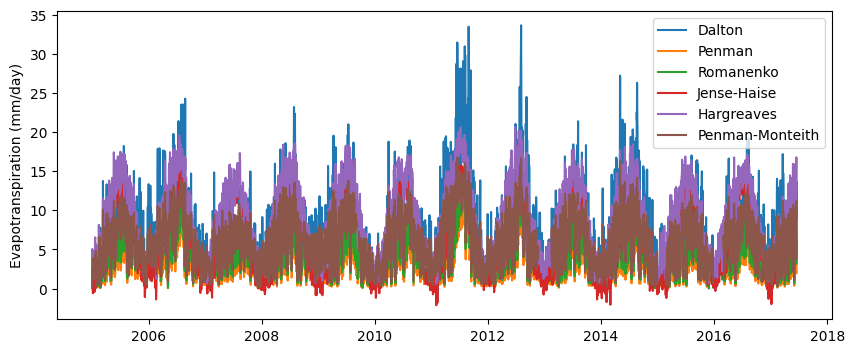

In [11]:
# Plot models
plt.figure(figsize=(10,4))
plt.plot(df['Date'], PET_dalton, label='Dalton')
plt.plot(df['Date'], PET_penman, label='Penman')
plt.plot(df['Date'], PET_romanenko, label='Romanenko')
plt.plot(df['Date'], PET_jensen_haise, label='Jense-Haise')
plt.plot(df['Date'], PET_hargreaves, label='Hargreaves')
plt.plot(df['Date'], PET_penman_monteith, label='Penman-Monteith')
plt.ylabel('Evapotranspiration (mm/day)')
plt.legend()
plt.show()


In [12]:
# Compare all models
df_models = pd.DataFrame({'date':df['Date'],'dalton':PET_dalton, 'penman':PET_penman, 'romanenko':PET_romanenko,
                         'jensen-haise':PET_jensen_haise, 'hargreaves':PET_hargreaves,
                         'penman_monteith':PET_penman_monteith})

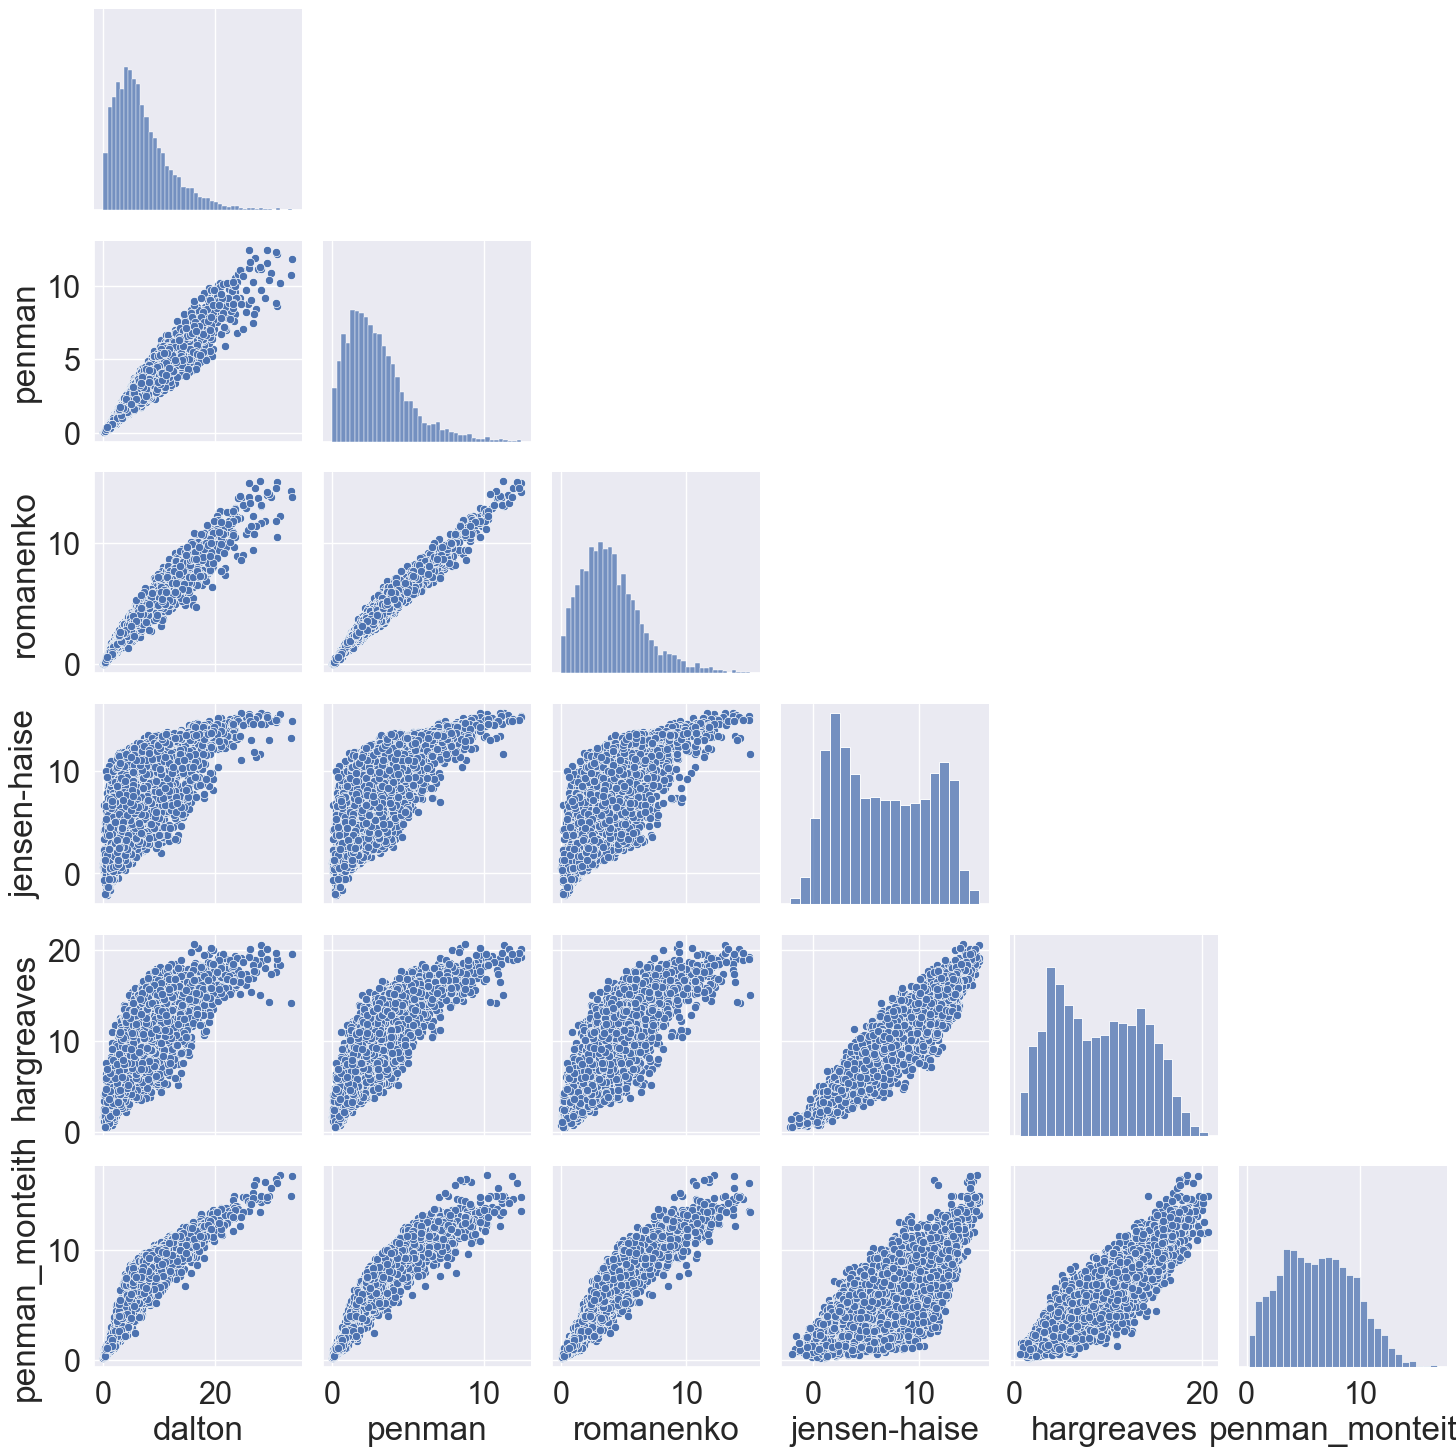

In [17]:
# Compare all models using a pairplot figure

sns.pairplot(df_models, corner=True)
sns.set(font_scale=2)


## Practice

- Calculate the mean absolute difference of all models against the Penman-Monteith model. What are the parsimonious models that best agree with the Penman-Monteith model? In what situations you may consider some of the simpler models?

- Using the Penman-Monteith model, what is the impact of wind speed? For instance, what is the impact on ETo when wind speed is increased by 1 m/s and maintaining all the other variables constant?


## References

Dalton J (1802) Experimental essays on the constitution of mixed gases; on the force of steam of vapour from waters and other liquids in different temperatures, both in a Torricellian vacuum and in air on evaporation and on the expansion of gases by heat. Mem Manch Lit Philos Soc 5:535–602

Hargreaves G (1989) Preciseness of estimated potential evapotranspiration. J Irrig Drain Eng 115(6):1000–1007

Penman HC (1948) Natural evaporation from open water, bare soil and grass. Proc R Soc Lond Ser A 193:120–145

Thornthwaite, C.W., 1948. An approach toward a rational classification of climate. Geographical review, 38(1), pp.55-94.

McMahon, T.A., Finlayson, B.L. and Peel, M.C., 2016. Historical developments of models for estimating evaporation using standard meteorological data. Wiley Interdisciplinary Reviews: Water, 3(6), pp.788-818.
